In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import time
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPool2D

# Data Pre-Processing

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [3]:
class_names = train_dataset.class_names

"""plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.show()"""

'plt.figure(figsize=(10, 10))\nfor images, labels in train_dataset.take(1):\n  for i in range(9):\n    ax = plt.subplot(3, 3, i + 1)\n    plt.imshow(images[i].numpy().astype("uint8"))\n    plt.title(class_names[labels[i]])\n    plt.axis("off")\n    plt.show()'

In [4]:
val_batches = tf.data.experimental.cardinality(validation_dataset) #nb of batches of data are available in the validation ds
test_dataset = validation_dataset.take(val_batches // 5) #we move 20% of them to a test set
validation_dataset = validation_dataset.skip(val_batches // 5)

In [5]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE) 
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
#convert the input images from RGB to BGR,
#then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
#Multiply inputs by scale and adds offset.

In [12]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet152(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

234708992/234698864 [==============================] - 6s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


# Feature Extraction

In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']     

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [18]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 5, 5, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 15s 316ms/step - loss: 1.1060 - accuracy: 0.3874


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.11
initial accuracy: 0.39


In [24]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 41s 473ms/step - loss: 0.8568 - accuracy: 0.5425 - val_loss: 0.5036 - val_accuracy: 0.7686
Epoch 2/10
63/63 [==============================] - 29s 463ms/step - loss: 0.4997 - accuracy: 0.7430 - val_loss: 0.2802 - val_accuracy: 0.8911
Epoch 3/10
63/63 [==============================] - 29s 463ms/step - loss: 0.3410 - accuracy: 0.8495 - val_loss: 0.1934 - val_accuracy: 0.9356
Epoch 4/10
63/63 [==============================] - 29s 461ms/step - loss: 0.2771 - accuracy: 0.8750 - val_loss: 0.1499 - val_accuracy: 0.9592
Epoch 5/10
63/63 [==============================] - 29s 462ms/step - loss: 0.2385 - accuracy: 0.8995 - val_loss: 0.1264 - val_accuracy: 0.9629
Epoch 6/10
63/63 [==============================] - 29s 463ms/step - loss: 0.2254 - accuracy: 0.8990 - val_loss: 0.1150 - val_accuracy: 0.9641
Epoch 7/10
63/63 [==============================] - 29s 462ms/step - loss: 0.1990 - accuracy: 0.9180 - val_loss: 0.1029 - val_accuracy: 0.9691

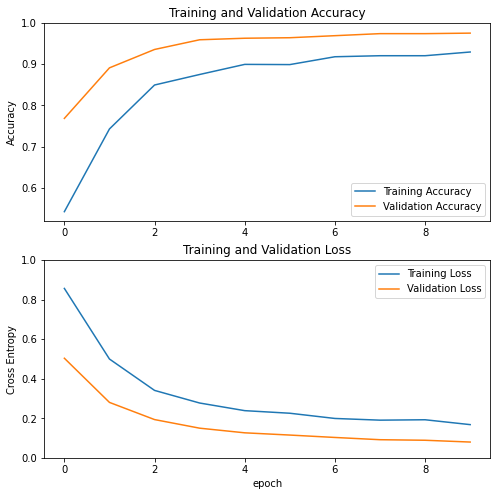

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#Fine Tuning

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  515


In [28]:
# Fine-tune from this layer onwards
fine_tune_at = 343

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet152 (Functional)      (None, 5, 5, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [31]:
len(model.trainable_variables)

210

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 73s 817ms/step - loss: 0.1160 - accuracy: 0.9535 - val_loss: 0.0508 - val_accuracy: 0.9851
Epoch 11/20
63/63 [==============================] - 48s 756ms/step - loss: 0.0817 - accuracy: 0.9670 - val_loss: 0.0560 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 48s 760ms/step - loss: 0.0655 - accuracy: 0.9725 - val_loss: 0.0505 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 48s 756ms/step - loss: 0.0571 - accuracy: 0.9755 - val_loss: 0.0252 - val_accuracy: 0.9901
Epoch 14/20
63/63 [==============================] - 48s 758ms/step - loss: 0.0497 - accuracy: 0.9800 - val_loss: 0.0206 - val_accuracy: 0.9938
Epoch 15/20
63/63 [==============================] - 48s 756ms/step - loss: 0.0472 - accuracy: 0.9810 - val_loss: 0.0346 - val_accuracy: 0.9913
Epoch 16/20
63/63 [==============================] - 48s 758ms/step - loss: 0.0306 - accuracy: 0.9875 - val_loss: 0.0235 - val_accuracy:

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

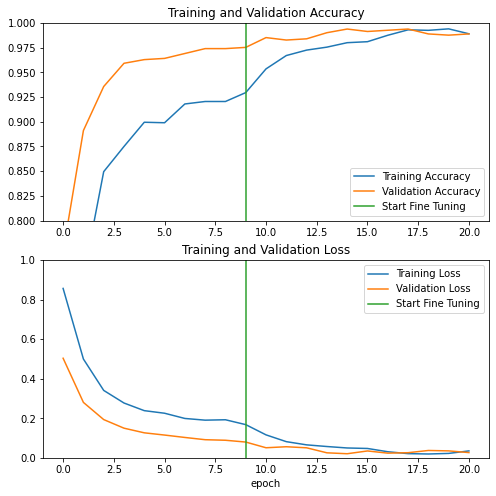

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()